## Import libraries and code

In [1]:
from database import csv_dataframe_creating as cs
import load_data as ld
import dataloaders as dl
import visualization as vis

import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit.Chem import rdMolTransforms as rdmt
from rdkit.Chem import rdShapeHelpers as rdshp
import molvs as mv
from rdkit.Geometry import rdGeometry 
from matplotlib.pyplot import spy
import matplotlib.pyplot as plt
from scipy import signal

import torch
from torch.utils import data as td
import torch.nn as nn
import torch.nn.functional as F

import time

import sqlite3

from sklearn.model_selection import train_test_split


#number of conformers created for every molecule
global NUM_CONFS
NUM_CONFS=100

#amount of chemical elements taking into account
global AMOUNT_OF_ELEM
AMOUNT_OF_ELEM=6

#size of batch
global BATCH_SIZE
BATCH_SIZE=10

#dimension of voxel with conformer
global VOXEL_DIM
VOXEL_DIM=70

#amount of target values
global TARGET_NUM
TARGET_NUM=12

## Creating dataframe with molecules and properties
example of code, needed datset already in `tox21_10k_data_all_no_salts.csv`

In [2]:
# #load dataset to dataframe
# data=cs.create_dataset()

# #delete repeating molecules values
# data=cs.del_duplicates(data)

# #delete molecules, that are not in sql database due to errors in rdkit
# data=cs.del_wrong_smiles(data)

## Loading data into dictionary

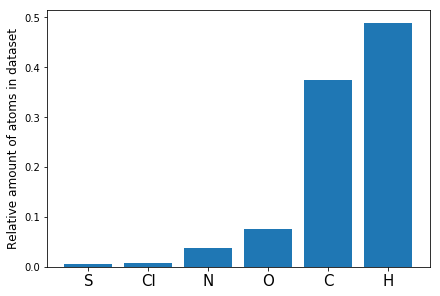

In [2]:
#get dataset without duplicates from csv
data=pd.read_csv('database/tox21_10k_data_all_no_salts.csv')

#create elements dictionary
elements=ld.create_element_dict(data,amount=AMOUNT_OF_ELEM)

#read databases to dictionary
conf_calc=ld.reading_sql_database()

#create indexing and label_dict for iteration
indexing,label_dict=ld.indexing_label_dict(data,conf_calc)

## Dataloaders pytorch

In [3]:
#create train and validation sets' indexes

train_indexes, test_indexes, _, _ = train_test_split(np.arange(0,len(conf_calc.keys())), np.arange(0,len(conf_calc.keys())), test_size=0.2, random_state=42)

# make dataloader for Gauss transformation
train_set_gauss = dl.Gauss_dataset(conf_calc,label_dict,elements,indexing,train_indexes,sigma=3)
train_generator_gauss = td.DataLoader(train_set_gauss,batch_size=BATCH_SIZE,shuffle=True)

test_set_gauss = dl.Gauss_dataset(conf_calc,label_dict,elements,indexing,test_indexes,sigma=3)
test_generator_gauss = td.DataLoader(test_set_gauss,batch_size=BATCH_SIZE,shuffle=True)


# make dataloader for Waves transformation
train_set_waves = dl.Waves_dataset(conf_calc,label_dict,elements,indexing,train_indexes,sigma=6)
train_generator_waves = td.DataLoader(train_set_waves,batch_size=BATCH_SIZE,shuffle=True)

test_set_waves = dl.Waves_dataset(conf_calc,label_dict,elements,indexing,test_indexes,sigma=6)
test_generator_waves = td.DataLoader(test_set_waves,batch_size=BATCH_SIZE,shuffle=True)


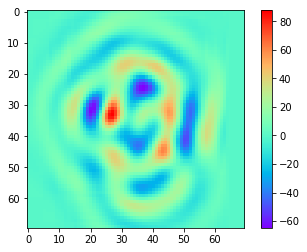

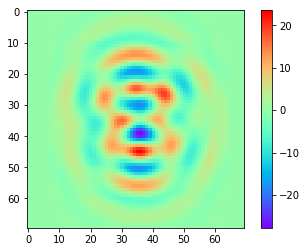

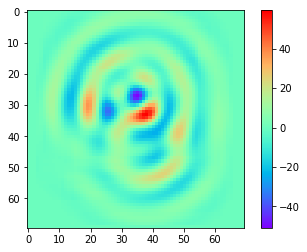

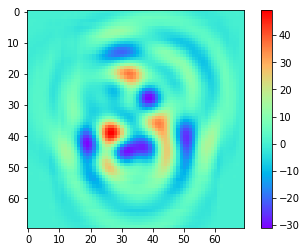

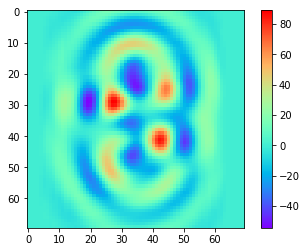

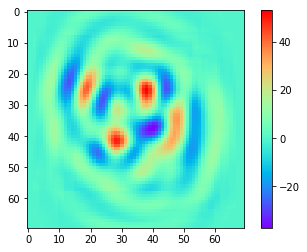

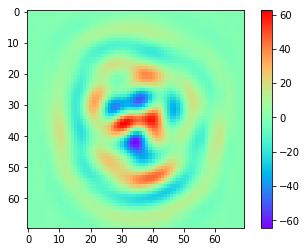

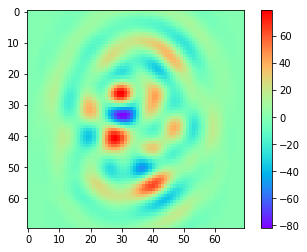

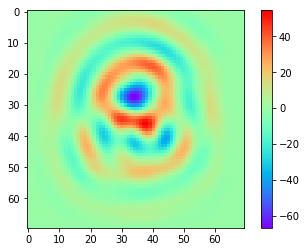

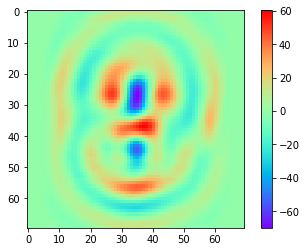

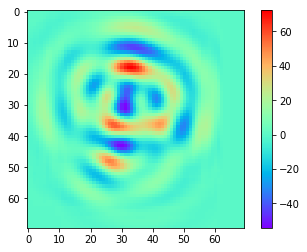

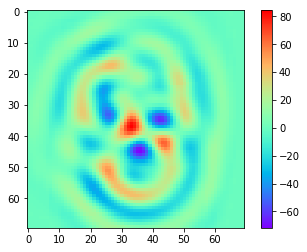

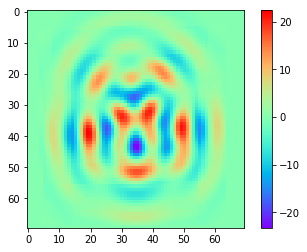

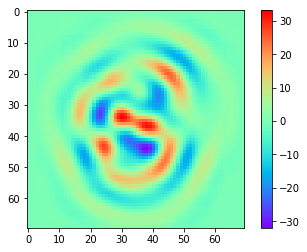

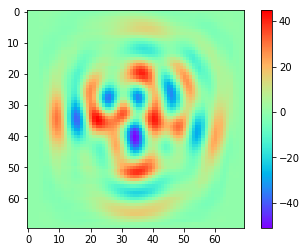

In [4]:
#visualize obtained results

dataloader_iterator = iter(training_generator_waves)
for i in range(15):
    volume, target = next(dataloader_iterator)
#     except StopIteration:
#         dataloader_iterator = iter(training_generator_waves)
#         volume, target = next(dataloader_iterator)
    volnp=volume[0,elements['H'],:,:,:].squeeze().numpy()
    volnp=volnp.sum(axis=2)
    vis.molecule_visualization2D([volnp])
#     print(smile)
#     s = VolToDx()(**{'volume':volume[:,:,:,:,1].squeeze().numpy(),'origin':np.array([-17.5,-17.5,-17.5]),'dsteps':np.array([0.5,0.5,0.5])})

In [2]:
#create neural net
class Net(nn.Module):
    def __init__(self, dim=70, num_elems=6,num_targets=12, batch_size=BATCH_SIZE):
        super(Net, self).__init__()
        
        #initialize dimensions
        self.dim=dim
        self.num_elems=num_elems
        self.num_targets=num_targets
        self.batch_size=batch_size
        
        #create layers
        self.conv1 = nn.Conv3d(num_elems, 32, kernel_size=(3,3,3))
        self.pool1=nn.MaxPool3d(kernel_size=(2,2,2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3,3,3))
        self.pool2=nn.MaxPool3d(kernel_size=(2,2,2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3,3,3))
        self.pool3=nn.MaxPool3d(kernel_size=(2,2,2))
        self.conv4 = nn.Conv3d(128, 256, kernel_size=(3,3,3))
        self.pool4=nn.MaxPool3d(kernel_size=(2,2,2))
        self.fc1 = nn.Linear(2048, num_targets)
        
        #initialize dense layer's weights
        nn.init.xavier_uniform_(self.fc1.weight)
        self.fc1.bias.data.fill_(0.01)
        
        
        self.convolution=nn.Sequential(
            self.conv1,
            self.pool1,
            self.conv2,
            self.pool2,
            self.conv3,
            self.pool3,
            self.conv4,
            self.pool4
        )
        
        def weights_init(m):
            if type(m)==nn.Conv3d:
                nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        #initialize convolutional layers' weights    
        self.convolution.apply(weights_init)

    def forward(self, x):

        x_conv=self.convolution(x)
        x_vect=x_conv.view(self.batch_size,-1)
        y = self.fc1(x_vect)
#         multi-label (not multi-class!) classification => sigmoid non-linearity
        return torch.sigmoid(y)


# Construct our model by instantiating the class defined above
model = Net(dim=VOXEL_DIM, num_elems=AMOUNT_OF_ELEM,num_targets=TARGET_NUM,batch_size=BATCH_SIZE)

#set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [3]:
#create train and validation functions

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_generator_waves):

        #set gradients to zero
        optimizer.zero_grad()
        
        #calculate output vector
        output = model(data)
        
        #create mask to get rid of Nan's in target
        mask=(target==target)
        output_masked=torch.masked_select(output,mask).type_as(output)
        target_masked=torch.masked_select(target,mask).type_as(output)
        
        #multi-label (not multi-class!) classification=>binary cross entropy loss
        loss = F.binary_cross_entropy(output_masked,target_masked)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_generator_waves.dataset),
                100. * batch_idx / len(train_generator_waves), loss.item()))

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        total=0
        for data, target in test_generator_waves:
            output = model(data)
            mask=(target==target)
            output_masked=torch.masked_select(output,mask).type_as(output)
            target_masked=torch.masked_select(target,mask).type_as(output)
            test_loss += F.binary_cross_entropy(output_masked,target_masked)
            pred = output_masked.ge(0.5).type_as(output)
            correct += pred.eq(target_masked).sum().item()
            total+=output_masked.shape[0]
        test_loss /= len(test_generator_waves.dataset)
        test_loss *= BATCH_SIZE
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, total,
                      100. * correct / total))

In [ ]:
#train procedure
for epoch in range(1,20+1):
    train(epoch)
    test()